In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from homework1_solution import *

# Homework 1 Solution Plots

## Load Cliffworld

In [2]:
env = cliffworld()

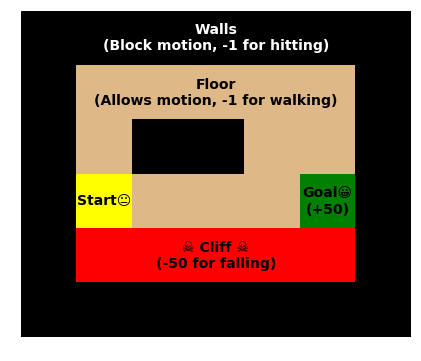

In [3]:
def square(x,y,**kw):
  plt.axhspan(y,y+1,xmin=x/7,xmax=(x+1)/7,**kw)

colors = {'#': 'black', '.': 'burlywood', 'X': 'red', '*': 'green', 'o': 'yellow'}

plt.figure(figsize=(7,6))

for y,row in enumerate(env.maze.topology):
  for x,cell in enumerate(row):
    square(x,5-y,color=colors[cell])
    
plt.axis('off')
plt.text(1.5,2.5,'Start😐', va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(5.5,2.5,"Goal😀\n(+50)", va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(3.5,1.5,"☠️ Cliff ☠️\n(-50 for falling)", va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(3.5,5.5,"Walls\n(Block motion, -1 for hitting)", color='white', va='center', ha='center', fontweight='bold', fontsize=14)
plt.text(3.5,4.5,"Floor\n(Allows motion, -1 for walking)", va='center', ha='center', fontweight='bold', fontsize=14)
plt.xlim(0,7)
plt.ylim(0,6)

plt.show()

## Run SARSA and Q-learning

In [4]:
trials_by_algo_and_params = {}

for method in ['SARSA', 'Q-learning']:
  for Q_initial in [0, 50, -50]:
    key = (method, Q_initial)
    
    t1 = time.time()
    print('Testing', key)
    
    trials_by_algo_and_params[key] = []
    for independent_run in range(50):
      trials_by_algo_and_params[key].append(
        run_simulation(env, method, Q_initial=Q_initial))
      
    t2 = time.time()
    print('Took {:.1f}s'.format(t2-t1))

Testing ('SARSA', 0)
Took 25.2s
Testing ('SARSA', 50)
Took 29.0s
Testing ('SARSA', -50)
Took 37.7s
Testing ('Q-learning', 0)
Took 22.3s
Testing ('Q-learning', 50)
Took 22.1s
Testing ('Q-learning', -50)
Took 38.3s


## Run Thompson Sampling

In [5]:
for dirichlet_prior, default_reward in [(1,50),(1,10),(10,50)]:
  key = ('Thompson', dirichlet_prior, default_reward)

  t1 = time.time()
  print('Testing', key)

  trials_by_algo_and_params[key] = []
  for independent_run in range(50):
    trials_by_algo_and_params[key].append(
      run_simulation(env, 'Thompson',
                     thompson_dirichlet_prior=dirichlet_prior,
                     thompson_default_reward=default_reward))

  t2 = time.time()
  print('Took {:.1f}s'.format(t2-t1))

Testing ('Thompson', 1, 50)
Took 40.1s
Testing ('Thompson', 1, 10)
Took 42.3s
Testing ('Thompson', 10, 50)
Took 48.9s


## Sanity-check policies

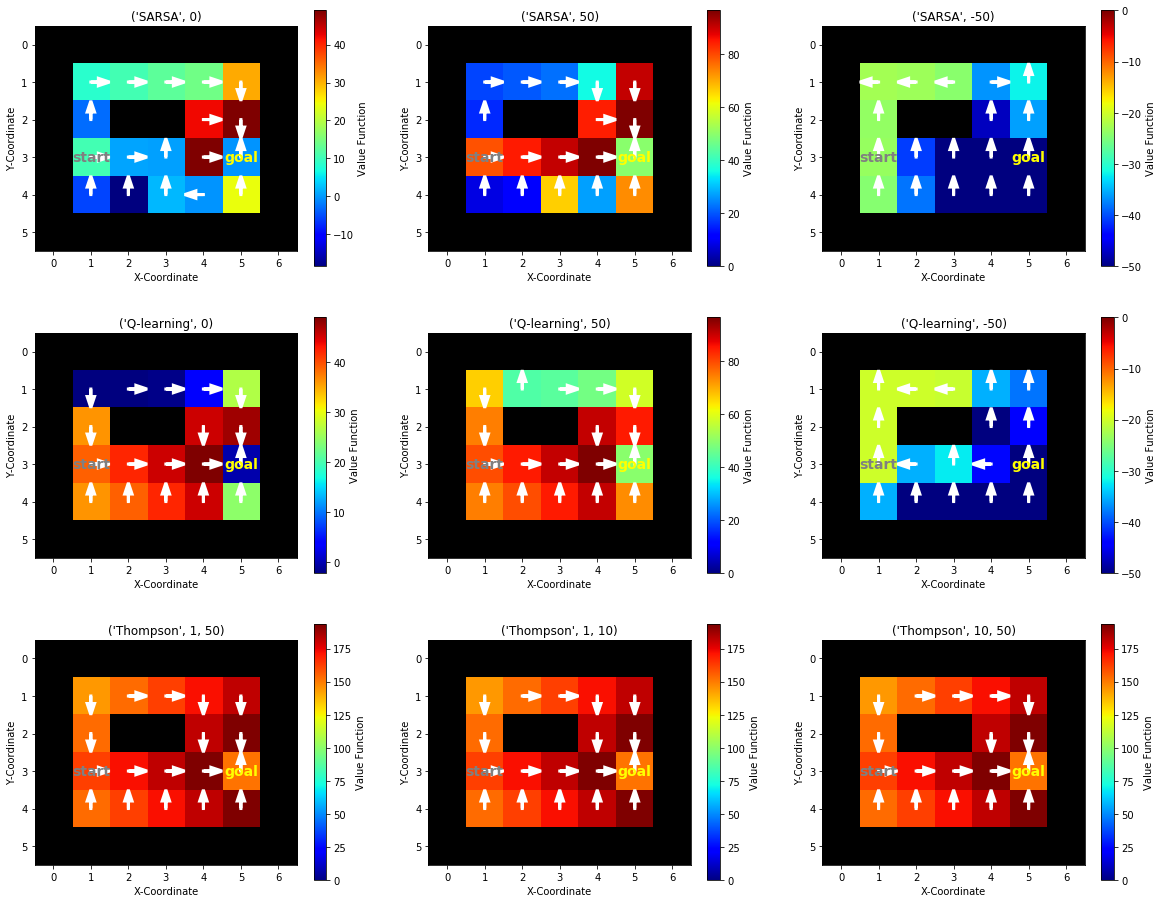

In [6]:
plt.figure(figsize=(20,16))
for i, (key, vals) in enumerate(trials_by_algo_and_params.items()):
  plt.subplot(3,3,i+1, title=key)
  plot_policy(env, vals[0]['Q'])

## Compare with true policy

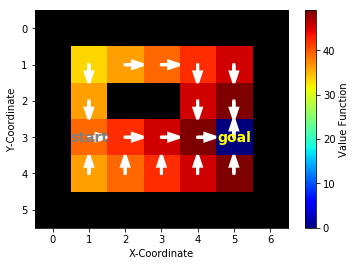

In [7]:
plot_policy(env, true_Q_function(env))

It looks like Thompson sampling consistently finds the optimal policy, though the actual value function estimates aren't correct.

Q-learning at $Q_{init} \in \{0,50\}$ finds a policy that is likely to be optimal for states that the agent realistically visits, though there are some errors in (less frequently visited) upper states.

SARSA at $Q_{init} \in \{0,50\}$ learns a different policy that involves going up and over the upper wall, which is safer if actions are assumed to be stochastic. This isn't optimal but it will still do pretty well.

SARSA and Q-learning with $Q_{init} = -50$ learn to hide in the upper-left corner, where there is the lowest possible chance of plummeting to the bottom of the cliff.

## Deliverable 1: Cumulative rewards while training

In [8]:
colors = {'SARSA': 'red', 'Q-learning': 'green', 'Thompson': 'blue'}
styles = {  (0,): '-',  (-50,): 'dotted',  (50,): '--',
          (1,50): '-', (10,50): 'dotted', (1,10): '--' }

def plot_trial(key):
  plot_means(trials_by_algo_and_params[key], color=colors[key[0]], ls=styles[key[1:]], label=key)
  
def plot_means(trials, lw=4, alpha=0.75, keep=100, **kw):
  rewards = np.array([np.cumsum(t['episode_rewards'][:keep]) for t in trials])
  plt.plot(rewards.mean(axis=0), lw=lw, alpha=alpha, **kw)

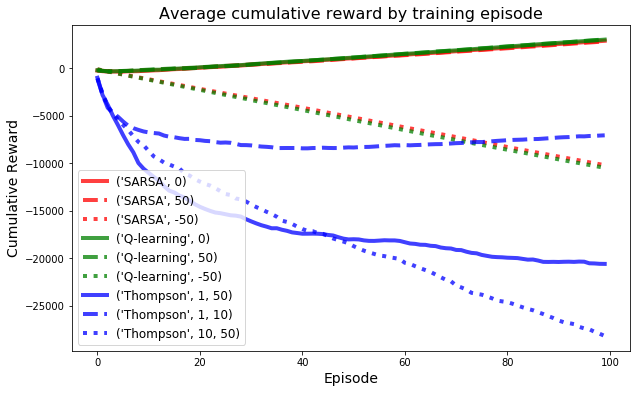

In [9]:
plt.figure(figsize=(10,6))
plt.title("Average cumulative reward by training episode", fontsize=16)

for key in trials_by_algo_and_params.keys():
  plot_trial(key)

plt.xlabel("Episode", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)

plt.legend(loc='best', fontsize=12)
plt.show()

There's a lot going on in this plot! Here are a few observations:
- Q-learning and SARSA (except at $Q_{init}=50$) seem to attain fairly high cumulative rewards during training.
- It's difficult to see, but Q-learning appears to do slightly better.
- Thompson sampling with Dirichlet prior psuedocount = 1 and default reward = 10 conducts some expensive exploration for a while, but ultimately starts increasing at an optimal slope, indicating that it has transitioned from exploration to exploitation. 
- Thompson sampling with Dirichlet prior psuedocount = 1 and default reward = 50 appears to be on the same track, but it will likely spend a longer period of time exploring. The same might hold for prior psuedocount = 10, but it will take even longer.

## Deliverable 2: Final episode rewards by $\epsilon$

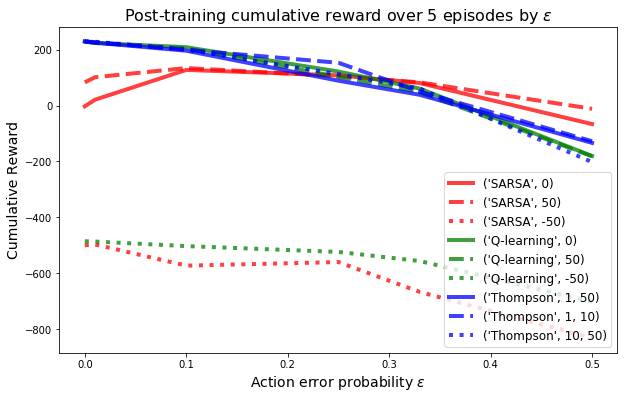

In [10]:
epsilons = [0, 0.01, 0.1, 0.25, 0.33, 0.5]

plt.figure(figsize=(10,6))
plt.title("Post-training cumulative reward over 5 episodes by $\epsilon$", fontsize=16)

for key, trials in trials_by_algo_and_params.items():
  Qs = [t['Q'] for t in trials]
  values = [
    np.mean([evaluate_static_policy(env, Q, num_episodes=5, epsilon=eps) for Q in Qs]) for eps in epsilons]
  plt.plot(epsilons, values, color=colors[key[0]], ls=styles[key[1:]], label=key, lw=4, alpha=0.75)
  
plt.ylabel("Cumulative Reward", fontsize=14)
plt.xlabel("Action error probability $\epsilon$", fontsize=14)

plt.legend(loc='best', fontsize=12)
plt.show()

This plot shows that Thompson sampling and Q-learning find an optimal deterministic policy, i.e. one that gives the maximum reward in the fully determinstic case. Interestingly, all of the Thompson sampling methods appear to ultimately discover the optimal policy (though only because of the final MAP estimation step we included at the end).

SARSA does a fair bit worse in the deterministic case, though when actions become stochastic, it starts outperforming the other methods.

## Deliverable 3: Number of catastrophic events

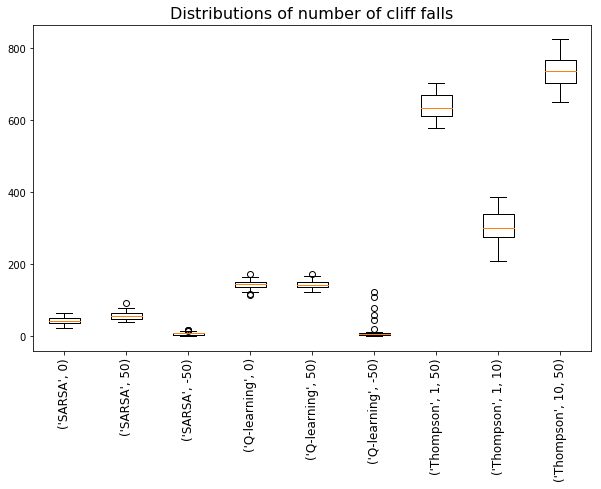

In [11]:
plt.figure(figsize=(10,6))
plt.title("Distributions of number of cliff falls", fontsize=16)

data = []
labels = []
for i, (key, trials) in enumerate(trials_by_algo_and_params.items()):
  falls = [t['num_cliff_falls'] for t in trials]
  data.append(falls)
  labels.append(key)
  
plt.boxplot(data)
plt.xticks(np.arange(9)+1, labels, rotation=90, fontsize=12)

plt.show()

Q-learning and SARSA both do a good job avoiding cliff-falls during training -- especially at $Q_{init}=-50$, when they seem to avoid them at all cost. However, as visualizations of the policies reveal above, they actually also avoid going near the goal state, and simply hang out in the corner until the episode terminates. That's not ideal.

At more reasonable $Q_{init}$s, SARSA generally incurs fewer falls than Q-learning, though we know this comes at the cost of worse performance in evaluation.

Finally, Thompson sampling incurs many falls, though the exact number is sensitive to the exploration/exploitation tradeoff set by its parameters.